In [28]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using Cubature

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

# Honeycomb lattice

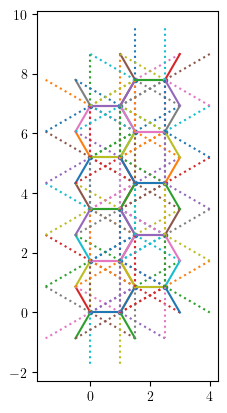

In [153]:
q = 5
B = 4pi / sqrt(3) / q

lattice = honeycomblattice(0, 1, 0, q - 1)

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., ".")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))...)
    end

    for n in nextneighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))..., ":")
    end
end


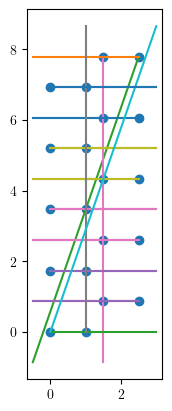

In [154]:
fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        norig = realspacecoordinates(n)
        nmap = realspacecoordinates(reducesite(n, 1, q))
        ax.plot([norig[1], nmap[1]], [norig[2], nmap[2]])
    end
end

# Hamiltonian

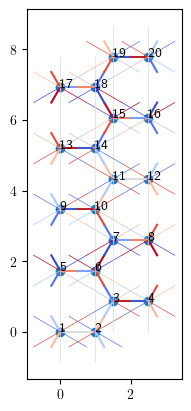

In [155]:
cm = get_cmap("coolwarm")

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for (i, rs) in enumerate(realspacecoordinates.(lattice.fromint))
    ax.annotate(i, xy=rs)
end

phimatrix = zeros(ComplexF64, 4q, 4q)
for (i, s) in enumerate(lattice.fromint)

    for n in neighbours(s)
        phi = peierls(B, s, n)
        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
    end

    for n in nextneighbours(s)
        phi = peierls(B, s, n)
        phiinv = peierls(B, n, s)

        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], linewidth=0.5, color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
        phimatrix[i, TCI.pos(lattice, reducesite(n, 1, q))] += exp(1im * phi)
    end
end

In [156]:
Ht = get_Ht(q, [pi / 2, 3], lattice)
#displaymatrix(Ht[:, 1, :, 1])
print("\nHt is hermitian: $([Ht[:, a, :, b] ≈ adjoint(Ht[:, a, :, b]) for a in 1:2, b in 1:2])")


Ht is hermitian: Bool[1 1; 1 1]

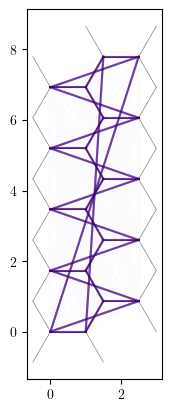

In [157]:
fig, ax = subplots()
displayhamiltonian(ax, abs.(Ht[:, 1, :, 1]), lattice)

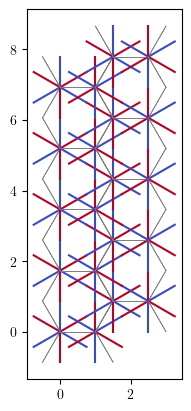

In [158]:
cm = get_cmap("coolwarm")

fig, ax = subplots()
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        for nn in neighbours(n)
            rs, rn, rnn = realspacecoordinates.([s, n, nn])
            ax.plot([rs[1], rn[1]], [rs[2], rn[2]], color="gray", linewidth=0.5)

            value = sign(antisymmetricproduct(rn - rs, rnn - rn))
            midpoint = (rs + rnn) / 2
            ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm((1 + value) / 2))
        end
    end
end


Hlambda is hermitian: Bool[1 1; 1 1]


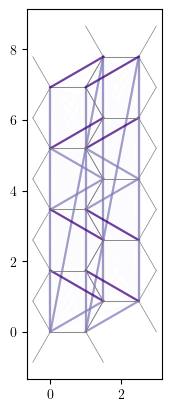

In [159]:
Hlambda = get_Hlambda(q, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(Hlambda[:, 1, :, 1]), lattice)

println("\nHlambda is hermitian: $([Hlambda[:, a, :, b] ≈ adjoint(Hlambda[:, a, :, b]) for a in 1:2, b in 1:2])")


HR is hermitian: Bool[1]


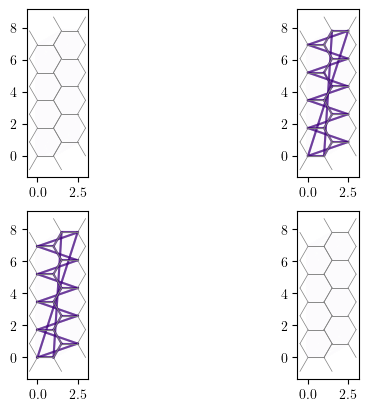

In [160]:
HR = get_HR(q, [0.0, 0.0], lattice)
vmax = maximum(abs.(HR))

fig, axs = subplots(2, 2)
for alpha in 1:2, beta in 1:2
    ax = axs[alpha, beta]
    ax.set_aspect(1)
    displayhamiltonian(ax, abs.(HR[:, alpha, :, beta]), lattice; vmax=vmax)
end

println("\nHR is hermitian: $([reshape(HR, 8q, 8q) ≈ adjoint(reshape(HR, 8q, 8q))])")

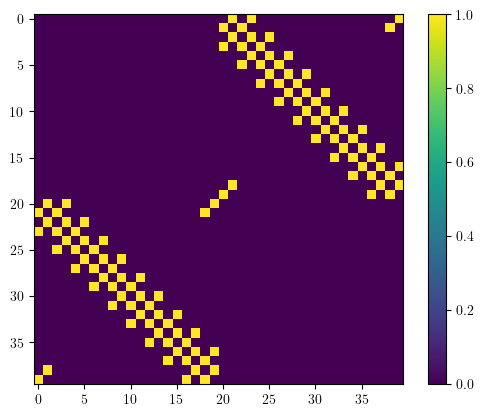

PyObject <matplotlib.colorbar.Colorbar object at 0x2a87cb250>

In [161]:
imshow(abs.(reshape(HR, 8q, 8q))) |> colorbar

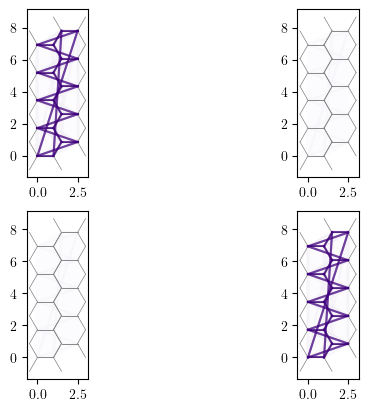

In [162]:
H = get_H(q, 0.06, 0.05, [0.0, 0.0], lattice; mass=0.4)
vmax = maximum(abs.(H))

fig, axs = subplots(2, 2)
for alpha in 1:2, beta in 1:2
    ax = axs[alpha, beta]
    ax.set_aspect(1)
    displayhamiltonian(ax, abs.(H[:, alpha, :, beta]), lattice; vmax=vmax)
end

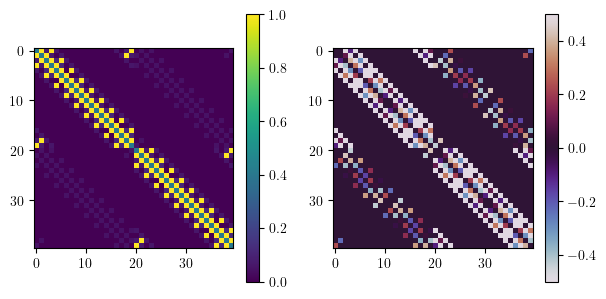

PyObject <matplotlib.colorbar.Colorbar object at 0x29f83a5e0>

In [163]:
fig, axs = subplots(ncols=2, figsize=(510/72, 250/72))
axs[1].imshow(abs.(reshape(H, 8q, 8q))) |> colorbar
axs[2].imshow(mod.(angle.(reshape(H, 8q, 8q)) .+ pi ./ 2, pi) ./ pi .- 0.5, cmap="twilight", vmin=-0.5, vmax=0.5) |> colorbar

# Band structure

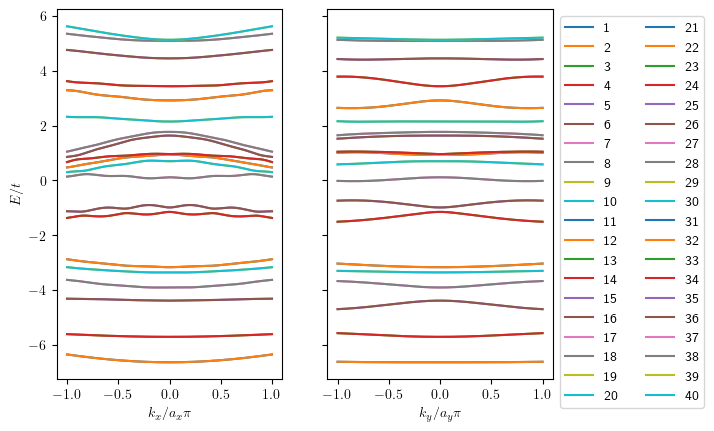

PyObject <matplotlib.legend.Legend object at 0x4b9160f40>

In [164]:
function bands(q, lambdaSO, lambdaR, kx, ky, mass)
    H = get_H(q, lambdaSO, lambdaR, [kx, ky], lattice; mass)
    return eigvals(reshape(H, 8q, 8q))
end

lambdaSO = 1.00 #/ (3 * sqrt(3))
lambdaR = 1.0
mass = 0.00

nquantics = 8
ndiscretization = 2^nquantics

BZedgex = pi / 1.5 / 2
kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
BZedgey = pi / sqrt(3) / q
kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, lambdaR, kxvals, 0, mass)
axs[1].plot(kxvals / BZedgex, [b for b in bandsx], "-", label=["$i" for i in eachindex(bandsx[1])])

#axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-", label=["$i up" for i in eachindex(bandsx[1][1])])
#axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--", label=["$i down" for i in eachindex(bandsx[1][2])])

bandsy = bands.(q, lambdaSO, lambdaR, 0, kyvals, mass)
axs[2].plot(kyvals / BZedgey, [b for b in bandsy], "-", label=["$i" for i in eachindex(bandsy[1])])

#axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-", label=["$i up" for i in eachindex(bandsy[1][1])])
#axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--", label=["$i down" for i in eachindex(bandsy[1][2])])


axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)

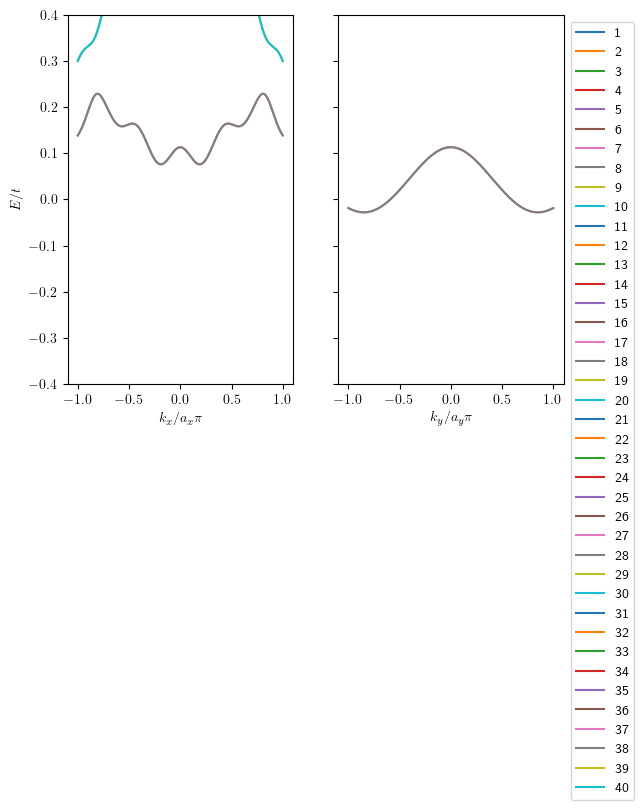

PyObject <matplotlib.legend.Legend object at 0x2a25cbac0>

In [165]:
fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, lambdaR, kxvals, 0, mass)
axs[1].plot(kxvals / BZedgex, [b for b in bandsx], "-", label=["$i" for i in eachindex(bandsx[1])])

#axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-", label=["$i up" for i in eachindex(bandsx[1][1])])
#axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--", label=["$i down" for i in eachindex(bandsx[1][2])])

bandsy = bands.(q, lambdaSO, lambdaR, 0, kyvals, mass)
axs[2].plot(kyvals / BZedgey, [b for b in bandsy], "-", label=["$i" for i in eachindex(bandsy[1])])

#axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-", label=["$i up" for i in eachindex(bandsy[1][1])])
#axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--", label=["$i down" for i in eachindex(bandsy[1][2])])

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[1].set_ylim(-0.4, 0.4)
axs[2].set_ylim(-0.4, 0.4)
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

# Eigenstates

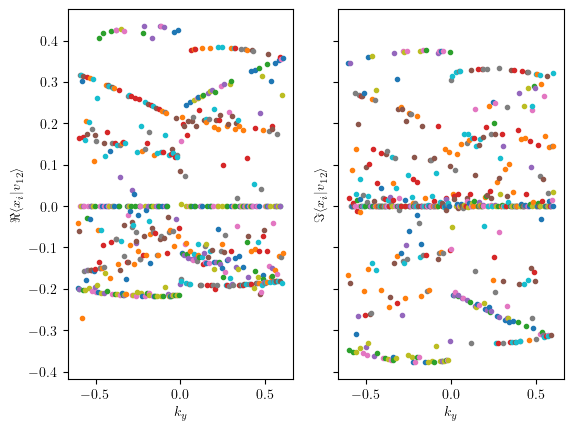

PyObject Text(327.68637510188574, 0.5, '$\\Im\\langle x_i | v_{12} \\rangle$')

In [133]:
function getstate(H, n=1:8q)
    values, vectors = eigen(reshape(H, 8q, 8q))
    ev = values[n]
    indices = filter(i -> any(values[i] .≈ ev), eachindex(values))
    return vectors[indices]
end

n = 12
states = [getstate(get_H(q, lambdaSO, lambdaR, [0, ky], lattice; mass), [n])[:] for ky in kyvals]

fig, axs = subplots(ncols=2, sharey=true)
for (ky, a) in zip(kyvals, states)
    axs[1].plot([ky], [real.(a)], ".")
    axs[2].plot([ky], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_y$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_y$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

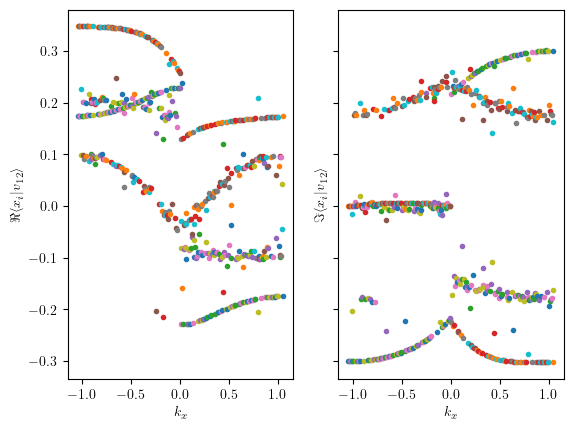

PyObject Text(327.68637510188574, 0.5, '$\\Im\\langle x_i | v_{12} \\rangle$')

In [134]:
states = [getstate(get_H(q, lambdaSO, lambdaR, [kx, 0], lattice; mass), [n])[:] for kx in kxvals]

fig, axs = subplots(ncols=2, sharey=true)
for (kx, a) in zip(kxvals, states)
    axs[1].plot([kx], [real.(a)], ".")
    axs[2].plot([kx], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_x$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_x$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

# Berry curvature

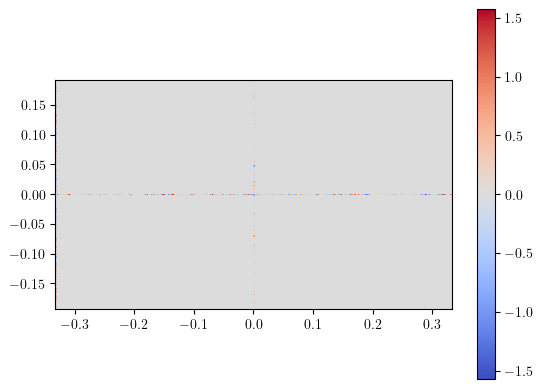

PyObject <matplotlib.colorbar.Colorbar object at 0x2ab3520a0>

In [135]:
ϵ = [BZedgex, BZedgey] ./ ndiscretization

Hcached = TCI.CachedFunction{Matrix{ComplexF64}}(
    kindex -> get_H(q, lambdaSO, lambdaR, [kxvals[kindex[1]], kyvals[kindex[2]]] .+ ϵ, lattice; mass)[:, 1, :, 1],
    [ndiscretization, ndiscretization]
)

H = [Hcached([kxi, kyi]) for kxi in 1:ndiscretization, kyi in 1:ndiscretization]
A = berrycurvature_dets(H, n)
maxval = maximum(abs.(A))
imshow(A, cmap="coolwarm", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi), vmin=-maxval, vmax=maxval) |> colorbar

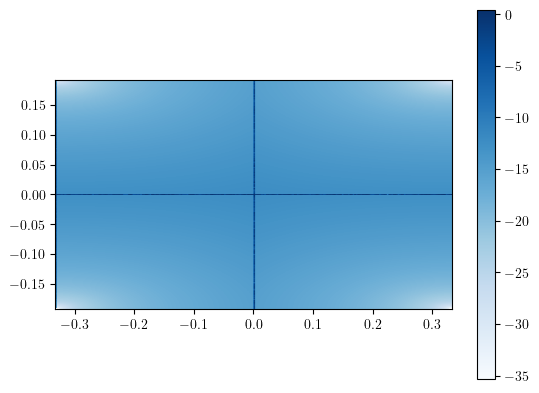

PyObject <matplotlib.colorbar.Colorbar object at 0x2adb2ce80>

In [136]:
fig, ax = subplots()
ax.imshow(log.(abs.(A)), cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar

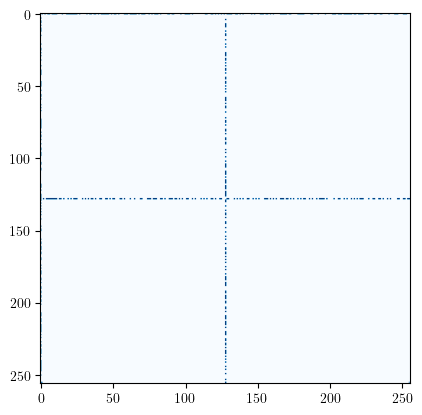

PyObject <matplotlib.image.AxesImage object at 0x2b0984460>

In [137]:
imshow(sign.(A), cmap="Blues")

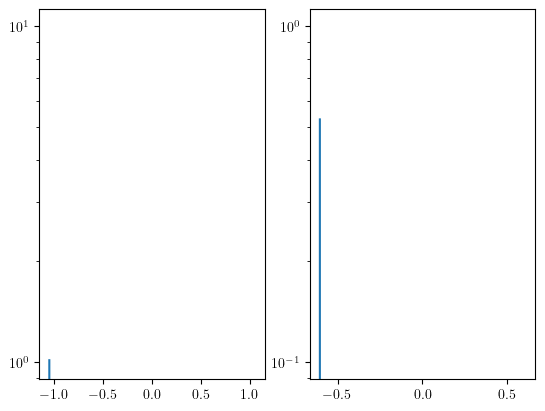

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b646ae50>

In [138]:
fig, axs = subplots(ncols=2)
axs[1].semilogy(kxvals, A[:, div(size(A, 2), 2)])
axs[2].semilogy(kyvals, A[div(size(A, 1), 2), :])

## Chern number through conventional sum

In [139]:
sum(A) / 2pi

4.071903356485438

## Band structure in 2d

Compare Berry curvature

In [108]:
band2d = [real(bands(q, lambdaSO, lambdaR, kx, ky, mass)[n]) for kx in kxvals, ky in kyvals]

256×256 Matrix{Float64}:
 -0.0338279  -0.0338219  -0.0338509  …  -0.0338509  -0.0338219  -0.0338279
 -0.0338198  -0.0338322  -0.0338722     -0.0338722  -0.0338322  -0.0338198
 -0.0338109  -0.0338353  -0.0338348     -0.0338348  -0.0338353  -0.0338109
 -0.0338014  -0.0338157  -0.0337967     -0.0337967  -0.0338157  -0.0338014
 -0.0337912  -0.0337954  -0.033758      -0.033758   -0.0337954  -0.0337912
 -0.0337804  -0.0337744  -0.0337186  …  -0.0337186  -0.0337744  -0.0337804
 -0.0337689  -0.0337528  -0.0336786     -0.0336786  -0.0337528  -0.0337689
 -0.0337567  -0.0337305  -0.0336379     -0.0336379  -0.0337305  -0.0337567
 -0.0337439  -0.0337076  -0.0335965     -0.0335965  -0.0337076  -0.0337439
 -0.0337305  -0.033684   -0.0335545     -0.0335545  -0.033684   -0.0337305
 -0.0337164  -0.0336598  -0.0335119  …  -0.0335119  -0.0336598  -0.0337164
 -0.0337017  -0.033635   -0.0334687     -0.0334687  -0.033635   -0.0337017
 -0.0336863  -0.0336095  -0.0334249     -0.0334249  -0.0336095  -0.0336863


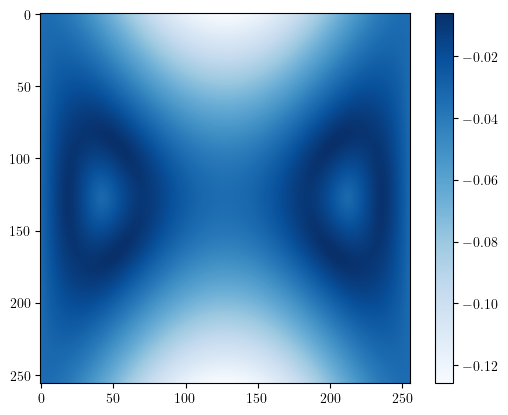

PyObject <matplotlib.colorbar.Colorbar object at 0x29ee9acd0>

In [109]:
imshow(band2d, cmap="Blues") |> colorbar

# Quantics TCI rep of Berry curvature

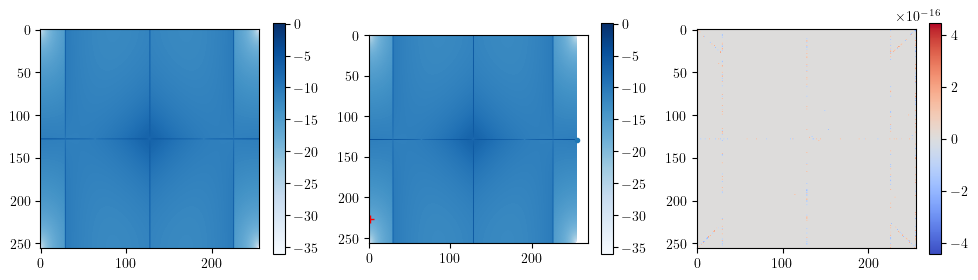

PyObject <matplotlib.colorbar.Colorbar object at 0x16bc4d700>

In [60]:
f(q) = berrycurvature_quantics_dets(Hcached, n, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(2, 2*nquantics))

fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(log.(abs.(A)), cmap="Blues") |> colorbar

quanticsdata = [
    f(interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in 1:ndiscretization, kyi in 1:ndiscretization
]

axs[2].imshow(log.(abs.(quanticsdata)), cmap="Blues") |> colorbar
axs[2].plot(quantics_to_index(firstpivot[1:2:end]), quantics_to_index(firstpivot[2:2:end]), ".")
axs[2].plot(Tuple(argmax(log.(abs.(A))))..., "r+")

axs[3].imshow(quanticsdata .- A, cmap="coolwarm") |> colorbar

In [64]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::TCI.MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::TCI.SweepStrategies.SweepStrategy=TCI.SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    errornormalization::Union{Nothing,Float64}=nothing,
    verbosity::Int=0
) where {ValueType}
    tci = TCI.TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    cherns = Float64[]
    ranks = Int[]
    N::Float64 = isnothing(errornormalization) ? abs(f(firstpivot)) : abs(errornormalization)

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == TCI.SweepStrategies.forward ||
            (sweepstrategy != TCI.SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            TCI.addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            TCI.addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        push!(errors, TCI.lastsweeppivoterror(tci) / N)
        push!(ranks, maximum(rank(tci)))
        push!(cherns, sumqtt(TCI.tensortrain(tci))  / 2pi)

        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    return tci, ranks, errors, cherns
end

tci, ranks, errors, cherns = crossinterpolate_chern(
    Float64,
    f,
    fill(2, 2*nquantics),
    firstpivot,
    tolerance=1e-6,
    maxiter=200,
)

(TensorCrossInterpolation.TensorCI{Float64} with ranks 56, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  47, 48, 49, 50, 51, 52, 53, 54, 55, 56], [5.350514158879034, 5.351247943628922, 5.3060442807085, 131.09036082888343, 10.459341673211728, 1.9615789017243483, 8.276699680049347, 2.564963770572591, 0.8938370922749465, 1.5477972865448497  …  1.68463774448652e-5, 1.2977885118381749e-5, 8.806264705947044e-6, 5.253131073721185e-6, 5.694950085497568e-6, 4.051571551217014e-6, 2.664694912176238e-6, 2.319510429797443e-6, 1.4381576907320305e-6, 7.069820680748152e-7], [-5.960160378925823, 2.2700021101494334, 0.8009853771788551, -588.7463773529184, 0.7964897954207462, 4.157570530676509, 0.7749151613103755, 0.5066053366444934, 0.4271571558603857, 1.1448794203408192  …  0.4999964947796338, 0.49999447907021055, 0.49999941247994184, 0.499998770075318, 0.49999927266629157, 0.4999986347885509, 0.5000002623415774, 0.50000048228119, 0.5000016874286459, 0.500001096747095])

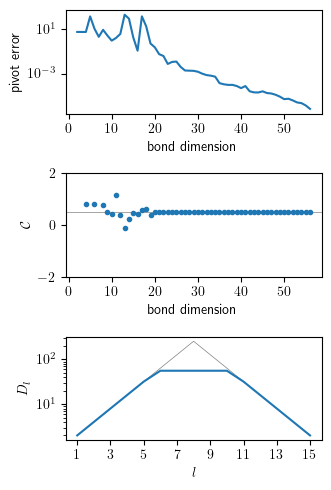

In [70]:
fig, axs = subplots(nrows=3, figsize=[246/72, 500/100])

axs[1].semilogy(ranks, errors)
axs[1].set_xlabel("bond dimension")
axs[1].set_ylabel("pivot error")

axs[2].axhline(0.5, color="gray", linewidth=0.5)
axs[2].plot(ranks, cherns, ".")
axs[2].set_xlabel("bond dimension")
axs[2].set_ylabel(L"$\mathcal{C}$")
axs[2].set_ylim(-2, 2)

axs[3].semilogy(1:2nquantics-1, maxlinkdim(2nquantics, 2)[2], color="gray", linewidth=0.5)
axs[3].semilogy(1:2nquantics-1, TCI.linkdims(tci))
axs[3].set_ylabel(L"$D_l$")
axs[3].set_xlabel(L"$l$")
axs[3].set_xticks(1:2:2nquantics-1)

tight_layout()

In [72]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in eachindex(kxvals), kyi in eachindex(kyvals)
]

256×256 Matrix{Float64}:
 -6.76803e-13  -6.45679e-6   -2.58668e-5   …  -6.50741e-6   -4.23371e-9
  1.03341e-11   7.58118e-13   7.59226e-12      7.48532e-13   1.22148e-14
  9.51771e-11  -8.82377e-12   3.01578e-11      2.08985e-12   5.73069e-13
 -4.62382e-13  -3.35655e-11  -7.09551e-11      6.0458e-12    3.23445e-12
 -6.33583e-10   1.51981e-11  -5.45419e-11      1.52099e-11   1.05736e-11
 -7.28973e-11   7.86659e-11   6.59838e-11  …   3.32142e-11   2.6236e-11
  2.41487e-10   5.7299e-11    1.47303e-10      6.47289e-11   5.48896e-11
  1.22181e-12   1.08282e-10   1.59498e-10      1.15475e-10   1.02252e-10
  3.43877e-11   1.92085e-10   2.6021e-10       1.9222e-10    1.75092e-10
  3.24544e-11   3.138e-10     4.01884e-10      3.02792e-10   2.81235e-10
 -2.13277e-13   4.75553e-10   5.84429e-10  …   4.55016e-10   4.29569e-10
 -3.75331e-11   6.80337e-10   8.12325e-10      6.61637e-10   6.30576e-10
 -4.03045e-11   9.31384e-10   1.0837e-9        9.31676e-10   8.93691e-10
  ⋮                         

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -12) = -12.0
vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = 0.03213388335201169


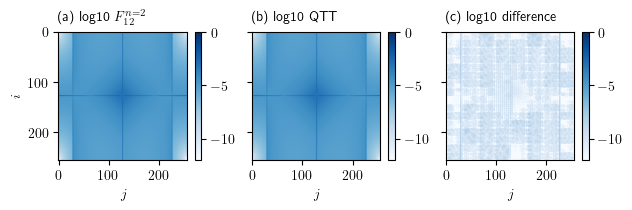

In [73]:
plottransform2(x) = log10(abs(x))
cmap = "Blues"

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -12)
@show vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=3, figsize=(510/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[3].imshow(plottransform2.(qttdata .- A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar

labels = [
    "(a) log10 \$F_{12}^{n=$n}\$",
    "(b) log10 QTT",
    "(c) log10 difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

In [74]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

sumqtt(qtt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(0.500001096747095, 0.5000002952468938, 0.499999999999998)

Comment: Chern number is calculated to an accuracy comparable to the TCI precision.

In [ ]:
fig, axs = subplots(ncols=2, figsize=(246/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap) |> colorbar
axs[2].imshow(plottransform2.(qttdata .- A), cmap=cmap) |> colorbar

labels = [
    "(a) log10 \$F_{12}^{n=$n}\$",
    "(b) log10 difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

In [ ]:
imshow(log.(abs.((qttdata .- A) ./ (qttdata .+ A) .* 2)), vmin=-8, cmap="RdYlBu_r") |> colorbar

In [ ]:
semilogy(1:2^nquantics, abs.(A[:, 33]))

# Berry curvature with derivative method

In [ ]:
# nquantics = 10
# ndiscretization = 2^nquantics

# BZedgex = pi / 1.5 / 2
# kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
# BZedgey = pi / sqrt(3) / q
# kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

Hfunc = (k -> get_H(q, lambdaSO, k, lattice)[:, 1, :, 1])
Hfuncderiv = ((k, derivdir) -> get_H(q, lambdaSO, k, lattice, derivative_direction=derivdir)[:, 1, :, 1])

berry_derivs = [
    berrycurvature_derivatives(Hfunc([kx, ky]), Hfuncderiv([kx, ky], 1), Hfuncderiv([kx, ky], 2), n)
    for kx in kxvals, ky in kyvals];

In [ ]:
fig, ax = subplots(figsize=(246/72, 120/72))
ax.imshow(berry_derivs, cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar
ax.set_xlabel(L"$k_x$")
ax.set_xlabel(L"$k_y$")

In [ ]:
plot(kxvals, berry_derivs[:, 1:8:end]);

In [ ]:
ndiscretization = 2^nquantics
bulkinds = 2:ndiscretization-1
cornerinds = [1, ndiscretization]
dk = 4 * BZedgex * BZedgey / ndiscretization^2 / 2pi^2
trapez = sum(berry_derivs[bulkinds, bulkinds]) +
    0.5 * (sum(berry_derivs[cornerinds, bulkinds]) + sum(berry_derivs[bulkinds, cornerinds])) +
    0.25 * (sum(berry_derivs[cornerinds, cornerinds]))
riemann = sum(berry_derivs)
trapez * dk, riemann * dk

In [ ]:
(val, err) = hcubature(
    k ->
    berrycurvature_derivatives(Hfunc(k), Hfuncderiv(k, 1), Hfuncderiv(k, 2), 8),
    [-BZedgex, -BZedgey], [BZedgex, BZedgey]
)

val / (2pi)^2

In [ ]:
kyplot = range(-BZedgey, BZedgey, length=4096)
berrycut = [
    berrycurvature_derivatives(Hfunc([BZedgex, ky]), Hfuncderiv([BZedgex, ky], 1), Hfuncderiv([BZedgex, ky], 2), n)
    for ky in kyplot]
plot(kyplot, berrycut)
plot(kyplot[1:8:end], berrycut[1:8:end])